<a href="https://colab.research.google.com/github/Rajesh-Khanna/NLP-Drug-review-classification/blob/master/Seq2Seq_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Glove Embedding
Embeding_D = 50

#Seq2Seq attention

# Download Dataset

In [0]:
!curl --output dataset.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
!unzip dataset.zip
# !rm dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40.9M  100 40.9M    0     0  50.2M      0 --:--:-- --:--:-- --:--:-- 50.2M
Archive:  dataset.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


In [0]:
import pandas as pd
import html
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.corpus import stopwords 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import gensim
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import h5py

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


#Loading Data
Tokenization,removing stopwords

In [0]:
# Loading Data

def load_dataset(filename,classes=0):
    df = pd.read_csv(filename, sep='\t')
    df.drop(df.columns[0], axis=1, inplace=True)
    df.drop(['drugName', 'condition', 'date', 'usefulCount'], axis=1, inplace=True)
    df['review'] = df['review'].apply(lambda x: x[1:-1])
    df['review'] = df['review'].apply(html.unescape)
    df['rating'] = df['rating'].astype('int64')
    df['label'] = 0

    print(df.groupby('rating').size())


    label_range = [0,4,6,10]
    if(classes == 2):
        label_range = [0,5,10]
    for i,r in enumerate(label_range):
        if(i == 0):
            continue
        df.label[(df['rating'] > label_range[i-1]) & (df['rating'] <=  label_range[i])] = i-1
    return df

# df = load_dataset("drugsComTrain_raw.tsv")
# df_test = load_dataset("drugsComTest_raw.tsv")
sequence_length = 100

In [0]:
stop_words = set(stopwords.words('english'))  
tokenizer = RegexpTokenizer(r'\w+')

In [0]:
def func(row):
    l = tokenizer.tokenize(row['review'])
    s = [i.lower() for i in l if i not in stop_words]
    return s
# df['processed'] = df.apply (lambda row: func(row), axis=1)


#Embedings

## Glove embedings

### Download Glove embeddings

In [0]:
!wget "http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip"
!unzip glove.6B.zip
!rm glove.6B.zip

--2019-11-24 16:17:36--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  1.85MB/s    in 6m 30s  

2019-11-24 16:24:06 (2.11 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


### Util functions

In [0]:
def embed(processed, w2v_dict, default_vec):
    vectors = []
    for w in processed:
        if(w in w2v_dict):
            vectors.append(w2v_dict[w])
        else:
            vectors.append(default_vec)
    vectors = np.array(vectors)
    return vectors

def embed_using_glove(df, embed_dim=50):
    # Load Glove embeddings.
    GLOVE_FILE = 'glove.6B.' + str(embed_dim) + 'd.txt'
    # Get number of vectors and hidden dimensions
    with open(GLOVE_FILE, 'r') as f:
        for i, line in enumerate(f):
            pass
    n_vec = i + 1
    hidden_dim = len(line.split(' ')) - 1
    # Find the average of all embeddings to be assigned to tokens not in the embeddings.
    # Create a word to vector dictionary for embedding.
    avg_vec = np.zeros((hidden_dim), dtype=np.float32)
    w2v_dict = {}
    count = 0
    with open(GLOVE_FILE, 'r') as f:
        for line in f:
            w2v_dict[line.split(' ')[:1][0]] = np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)
            avg_vec += np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)
            count+=1
    avg_vec/=count

    df['vectors'] = df.apply(lambda row: embed(row['processed'], w2v_dict, avg_vec), axis=1)
    return avg_vec

### Convert tokens in to Glove embeddings and save them to file.

In [0]:

# embed_using_glove(df_train, 50)
#df_train.to_pickle("train_glove_50.pckl")
# embed_using_glove(df_test, 50)
# df_test.to_pickle("test_glove_50.pckl")


## Word2Vec embeddings

### Download the Google word2vec embeddings

In [0]:
!curl --output word2vec.bin.gz https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
!gunzip word2vec.bin.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1570M  100 1570M    0     0  44.6M      0  0:00:35  0:00:35 --:--:-- 45.8M


### Load the word2vec embeddings into memory

### Util funcitons

In [0]:
def embed_w2v(processed, w2v_dict, default_vec):
    vectors = []
    for w in processed:
        if(w in w2v_dict):
            vectors.append(w2v_dict[w])
        else:
            vectors.append(default_vec)
    vectors = np.array(vectors)
    return vectors


### Get equal-class versions of train and test dataset

In [0]:
# df_test_w2v['label'].value_counts()
# df_test_w2v

In [0]:
# df_train_w2v = pd.concat([df_train[df_train['label']==0].sample(n=4829).reset_index(drop=True),df_train[df_train['label']==1].sample(n=4829).reset_index(drop=True),df_train[df_train['label']==2].sample(n=4829).reset_index(drop=True)],ignore_index=True)
# df_test_w2v = pd.concat([df_test[df_test['label']==0].sample(n=4829).reset_index(drop=True),df_test[df_test['label']==1].sample(n=4829).reset_index(drop=True),df_test[df_test['label']==2].sample(n=4829).reset_index(drop=True)],ignore_index=True)

### Convert the tokens into Word2Vec embeddings

In [0]:
# w2v_avg = np.average(w2v_model.vectors, axis=0)
# df_train_w2v['vectors'] = df_train_w2v.apply(lambda row: embed_w2v(row['processed'], w2v_model, w2v_avg), axis=1)
# df_test_w2v['vectors'] = df_test_w2v.apply(lambda row: embed_w2v(row['processed'], w2v_model, w2v_avg), axis=1)

### Save the Embeddings to file

In [0]:
# df_train_w2v.to_pickle("train_w2v.pckl")
# df_test_w2v.to_pickle("test_w2v.pckl")

In [0]:
def embeding_using_w2v(df):
    from gensim.models import KeyedVectors
    w2v_model = KeyedVectors.load_word2vec_format('word2vec.bin', binary=True)
    w2v_avg = np.average(w2v_model.vectors, axis=0)

    df['vectors'] = df.apply(lambda row: embed_w2v(row['processed'], w2v_model, w2v_avg), axis=1)
    df['vectors'] = df.apply(lambda row: embed_w2v(row['processed'], w2v_model, w2v_avg), axis=1)    
    return w2v_avg

## Elmo embeddings

### Install allennlp

In [0]:
!pip install allennlp

     |████████████████████████████████| 7.6MB 4.7MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 256kB 50.2MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 194kB 39.0MB/s 
     |████████████████████████████████| 133kB 50.8MB/s 
     |████████████████████████████████| 163kB 55.0MB/s 
     |████████████████████████████████| 245kB 50.5MB/s 
     |████████████████████████████████| 645kB 42.3MB/s 
     |████████████████████████████████| 1.0MB 37.1MB/s 
  Created wheel for word2number: filename=word2number-1.1-cp36-none-any.whl size=5588 sha256=e441dd3f106a9705b2a37836ee4194672275a95da52c307372442d69352f639c
  Stored in directory: /root/.cache/pip/wheels/46/2f/53/5f5c1d275492f2fce1cdab9a9bb12d49286dead829a4078e0e
  Created wheel for ftfy: filename=ftfy-5.6-cp36-none-any.whl size=44553 sha256=969cfc2dea1ef7dd1b247c4bbde7d45dcc21e858e1e7b004deb9bf8de04a418b
  Stored in directory: /root/.cache

### Imports

In [0]:
from allennlp.commands.elmo import ElmoEmbedder
import sys

### Util functions

In [0]:
avg_elmo_embedding = ['1']
def create_elmo_embeddings(elmo, documents, max_sentences = 1000):
    num_sentences = min(max_sentences, len(documents)) if max_sentences > 0 else len(documents)
    print("\n\n:: Lookup of " + str(num_sentences) + " ELMo representations. This takes a while ::")
    embeddings = []
    tokens = documents['processed'].to_numpy()
    
    documentIdx = 0
    for elmo_embedding in elmo.embed_sentences(tokens):  
        document = documents.iloc[documentIdx]
        # Average the 3 layers returned from ELMo
        avg_elmo_embedding = np.average(elmo_embedding, axis=0)             
        embeddings.append(avg_elmo_embedding)        
        
        # Some progress info
        documentIdx += 1
        percent = 100.0 * documentIdx / num_sentences
        line = '[{0}{1}]'.format('=' * int(percent / 2), ' ' * (50 - int(percent / 2)))
        status = '\r{0:3.0f}%{1} {2:3d}/{3:3d} sentences'
        sys.stdout.write(status.format(percent, line, documentIdx, num_sentences))
        
        if max_sentences > 0 and documentIdx >= max_sentences:
            break
            
    return embeddings


### Get smaller versions of train and test dataset

In [0]:
# df_train_elmo = df_train.sample(n=int(df_train.shape[0]/20)).reset_index(drop=True)
# df_test_elmo = df_test.sample(n=int(df_test.shape[0]/20)).reset_index(drop=True)

### Get ELMo embeddings

In [0]:
# elmo = ElmoEmbedder(cuda_device=0) #Set cuda_device to the ID of your GPU if you have one
# df_train_elmo['elmo_embeddings'] = create_elmo_embeddings(elmo, df_train_elmo, -1)
# df_test_elmo['elmo_embeddings'] = create_elmo_embeddings(elmo, df_test_elmo, -1)

In [0]:
def embeding_using_elmo(df):
    elmo = ElmoEmbedder(cuda_device=0) #Set cuda_device to the ID of your GPU if you have one
    df['vectors'] = create_elmo_embeddings(elmo, df, -1)
    return np.full_like(range(1024),0.0)

#Padding
Sequence length = 100

In [0]:
sequence_length = 100
num_classes = 3

In [0]:
def v2w(vec,avg_vec,w2v_dict):
    if((vec==avg_vec).all()):
        return 'UNK'
    if(np.all(vec == 0)):
        return 'None'
    for k in w2v_dict:
        if((w2v_dict[k]==vec).all()):
            return k
    return 'OOV'

# GetData

In [0]:
def getData(normalize = False,k = -1,k_test = 1000,classes=3,embed = 'glove'):
    df_train = load_dataset("drugsComTrain_raw.tsv",classes)
    df_test = load_dataset("drugsComTest_raw.tsv",classes)
    
    print(df_train.groupby('label').size())
    print(df_test.groupby('label').size())


    if(normalize):
        mn = df_train.groupby('label').size().min()
        if(classes == 3):
            df_train = pd.concat([df_train[df_train['label']==0].sample(n=mn).reset_index(drop=True),df_train[df_train['label']==1].sample(n=mn).reset_index(drop=True),df_train[df_train['label']==2].sample(n=mn).reset_index(drop=True)],ignore_index=True)
        else:
            df_train = pd.concat([df_train[df_train['label']==0].sample(n=mn).reset_index(drop=True),df_train[df_train['label']==1].sample(n=mn).reset_index(drop=True)],ignore_index=True)
        mn = df_test.groupby('label').size().min()
        if(classes == 3):
            df_test = pd.concat([df_test[df_test['label']==0].sample(n=mn).reset_index(drop=True),df_test[df_test['label']==1].sample(n=mn).reset_index(drop=True),df_test[df_test['label']==2].sample(n=mn).reset_index(drop=True)],ignore_index=True)
        else:
            df_test = pd.concat([df_test[df_test['label']==0].sample(n=mn).reset_index(drop=True),df_test[df_test['label']==1].sample(n=mn).reset_index(drop=True)],ignore_index=True)

    if(k!=-1):
        df_train = df_train.sample(n=k).reset_index(drop=True)

    if(k_test!=-1):
        df_test = df_test.sample(n=k_test).reset_index(drop=True)

    df_train['processed'] = df_train.apply (lambda row: func(row), axis=1)
    df_test['processed'] = df_test.apply (lambda row: func(row), axis=1)

    if(embed == 'glove'):
        w2v_avg = embed_using_glove(df_train, 50)
        w2v_avg = embed_using_glove(df_test, 50)

    if(embed == 'w2v'):
        w2v_avg = embeding_using_w2v(df_train)
        w2v_avg = embeding_using_w2v(df_test)

    if(embed == 'elmo'):
        w2v_avg = embeding_using_elmo(df_train)
        w2v_avg = embeding_using_elmo(df_test)

    # df_train['vectors'] = df_train.apply (lambda row: foo(row['processed']), axis=1)
    # df_test['vectors'] = df_test.apply (lambda row: foo(row['processed']), axis=1)

    train_data = pad_sequences(df_train['vectors'], maxlen=sequence_length,dtype='float32')
    train_labels = pd.get_dummies(df_train['label']).to_numpy().reshape(-1,1,classes)

    test_data = pad_sequences(df_test['vectors'], maxlen=sequence_length,dtype='float32')
    test_labels = pd.get_dummies(df_test['label']).to_numpy().reshape(-1,1,classes)

    _GO=np.array([[range(classes)]]*train_labels.shape[0])
    _GO_test=np.array([[range(classes)]]*test_labels.shape[0])
    _GO.shape

    print(df_train.groupby('label').size())
    print(df_test.groupby('label').size())

    xTrain = {'ex':train_data,'dx':_GO}
    xTest = {'ex':test_data,'dx':_GO_test}
    print(train_data.shape,test_data.shape)

    return xTrain,xTest,train_labels,test_labels

#Model

In [0]:
from tensorflow.keras.layers import Input,GRU,Attention,Bidirectional,Concatenate,RepeatVector,dot,Activation,concatenate,Dense,TimeDistributed
from tensorflow.keras.models import Model

In [0]:
def seq2seq(embed,classes=3):

    if(embed == 'glove'):
        EMBEDDING_D = 50
    if(embed == 'w2v'):
        EMBEDDING_D = 300
    if(embed == 'elmo'):
        EMBEDDING_D = 1024

    encoder_inputs = Input(batch_shape=(None, sequence_length, EMBEDDING_D), name='ex')
    decoder_inputs = Input(batch_shape=(None, 1, classes), name='dx')

    # Encoder network
    encoder_gru = Bidirectional(GRU(64, return_sequences=True, return_state=True, name='encoder_gru'),merge_mode='concat')
    encoder_out, state_h,state_c = encoder_gru(encoder_inputs)
    encoder_state = [state_h,state_c]
    print(encoder_out.shape)
    print(state_h.shape)
    print(state_c.shape)


    # Decoder network
    decoder_gru = Bidirectional(GRU(64, return_sequences=True, return_state=True, name='decoder_gru'),merge_mode='concat')
    decoder_out, _,_ = decoder_gru(decoder_inputs, initial_state=encoder_state)

    print(decoder_out.shape)

    #Attention Layer
    attn_out = dot([decoder_out, encoder_out], axes=[2, 2])

    print(attn_out.shape)

    attention = Activation('softmax')(attn_out)

    context = dot([attention, encoder_out], axes=[2,1])

    decoder_concat_input = concatenate([context, decoder_out])

    # decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

    dense = Dense(classes, activation='softmax', name='softmax_layer')
    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    decoder_pred = dense_time(decoder_concat_input)

    full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
    full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    attention_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=attention)
    full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return full_model,attention_model

#Training

##Glove

In [0]:
xTrain,xVal,yTrain,yVal = getData(normalize=True,k=10000)
full_model,attention_model = seq2seq(embed='glove')

rating
1     21619
2      6931
3      6513
4      5012
5      8013
6      6343
7      9456
8     18890
9     27531
10    50989
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rating
1      7299
2      2334
3      2205
4      1659
5      2710
6      2119
7      3091
8      6156
9      9177
10    17016
dtype: int64
label
0     40075
1     14356
2    106866
dtype: int64
label
0    13497
1     4829
2    35440
dtype: int64
label
0    3302
1    3363
2    3335
dtype: int64
label
0    331
1    352
2    317
dtype: int64
(10000, 100, 50) (1000, 100, 50)
(?, 100, 128)
(?, 64)
(?, 64)
(?, 1, 128)
(?, 1, 100)


In [0]:
training = full_model.fit(x=xTrain, y = yTrain, epochs=15, batch_size=128,validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/15
9000/9000 [==============================] - 17s 2ms/sample - loss: 1.0831 - acc: 0.3940 - val_loss: 1.0522 - val_acc: 0.4430
Epoch 2/15
9000/9000 [==============================] - 15s 2ms/sample - loss: 1.0287 - acc: 0.4710 - val_loss: 1.0022 - val_acc: 0.5060
Epoch 3/15
9000/9000 [==============================] - 15s 2ms/sample - loss: 0.9976 - acc: 0.4957 - val_loss: 0.9829 - val_acc: 0.5100
Epoch 4/15
9000/9000 [==============================] - 15s 2ms/sample - loss: 0.9677 - acc: 0.5167 - val_loss: 0.9677 - val_acc: 0.5160
Epoch 5/15
9000/9000 [==============================] - 15s 2ms/sample - loss: 0.9525 - acc: 0.5259 - val_loss: 0.9544 - val_acc: 0.5270
Epoch 6/15
9000/9000 [==============================] - 15s 2ms/sample - loss: 0.9205 - acc: 0.5546 - val_loss: 0.9620 - val_acc: 0.5240
Epoch 7/15
9000/9000 [==============================] - 15s 2ms/sample - loss: 0.8983 - acc: 0.5723 - val_loss: 0.9309 - val_acc: 

In [0]:
from sklearn.metrics import classification_report
import numpy as np

Y_test = np.argmax(yVal, axis=2).reshape((-1)) # Convert one-hot to index
y_pred = full_model.predict(xVal)
y_pred = y_pred.argmax(axis=2).reshape((-1))
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.55      0.55       331
           1       0.49      0.41      0.45       352
           2       0.56      0.65      0.60       317

    accuracy                           0.53      1000
   macro avg       0.53      0.54      0.53      1000
weighted avg       0.53      0.53      0.53      1000



(3.0, 0.0)

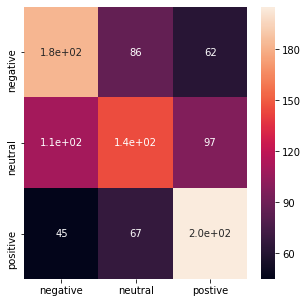

In [0]:
from sklearn import metrics
cm=metrics.confusion_matrix(Y_test,y_pred)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ['negative','neutral','positive'],
                  columns = ['negative','neutral','postive'])
plt.figure(figsize = (5,5))

ax = sn.heatmap(df_cm, annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

(3.0, 0.0)

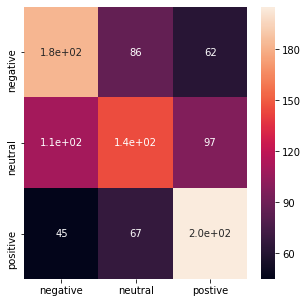

In [0]:
from sklearn import metrics
cm=metrics.confusion_matrix(Y_test,y_pred)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ['negative','neutral','positive'],
                  columns = ['negative','neutral','postive'])
plt.figure(figsize = (5,5))

ax = sn.heatmap(df_cm, annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [0]:
y_pred = attention_model.predict(xVal)
y_pred_class = full_model.predict(xVal)

req = np.argmax(y_pred,axis = 2).reshape((-1))
classes = np.argmax(y_pred_class,axis=2).reshape(-1)
imp_vecs = xVal
pos_words = []
neg_words = []
neu_words = []
for i,vecs in enumerate(imp_vecs):
    if(classes[i] == 0):
        neg_words.append({'word':v2w(vecs)})
    if(classes[i] == 1):
        neu_words.append({'word':v2w(vecs)})
    if(classes[i] == 2):
        pos_words.append({'word':v2w(vecs)})

neg_words = pd.DataFrame(neg_words)
neu_words = pd.DataFrame(neu_words)
pos_words = pd.DataFrame(pos_words)

print(neg_words['word'].value_counts())
print(neu_words['word'].value_counts())
print(pos_words['word'].value_counts())

NameError: ignored

##Word2Vec

In [0]:
xTrain,xVal,yTrain,yVal = getData(normalize=True,k=10000,embed='w2v')


rating
1     21619
2      6931
3      6513
4      5012
5      8013
6      6343
7      9456
8     18890
9     27531
10    50989
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rating
1      7299
2      2334
3      2205
4      1659
5      2710
6      2119
7      3091
8      6156
9      9177
10    17016
dtype: int64
label
0     40075
1     14356
2    106866
dtype: int64
label
0    13497
1     4829
2    35440
dtype: int64


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


label
0    3304
1    3349
2    3347
dtype: int64
label
0    334
1    351
2    315
dtype: int64
(10000, 100, 300) (1000, 100, 300)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(?, 100, 128)
(?, 64)
(?, 64)
(?, 1, 128)
(?, 1, 100)


In [0]:
full_model,attention_model = seq2seq(embed='w2v')

(?, 100, 128)
(?, 64)
(?, 64)
(?, 1, 128)
(?, 1, 100)


In [0]:
training = full_model.fit(x=xTrain, y = yTrain, epochs=15, batch_size=128,validation_split=0.1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 9000 samples, validate on 1000 samples
Epoch 1/15
9000/9000 [==============================] - 24s 3ms/sample - loss: 1.0641 - acc: 0.4230 - val_loss: 0.9801 - val_acc: 0.5390
Epoch 2/15
9000/9000 [==============================] - 22s 2ms/sample - loss: 0.9571 - acc: 0.5342 - val_loss: 0.9254 - val_acc: 0.5770
Epoch 3/15
9000/9000 [==============================] - 22s 2ms/sample - loss: 0.9138 - acc: 0.5637 - val_loss: 0.9248 - val_acc: 0.5570
Epoch 4/15
9000/9000 [==============================] - 22s 2ms/sample - loss: 0.8834 - acc: 0.5809 - val_loss: 0.8941 - val_acc: 0.5920
Epoch 5/15
9000/9000 [==============================] - 22s 2ms/sample - loss: 0.8542 - acc: 0.5989 - val_loss: 0.9024 - val_acc: 0.5650
Epoch 6/15
9000/9000 [==============================] - 22s 2ms/sample - loss: 0.8282 - acc: 0.6160 - val_loss: 0.9032 - val_acc: 0.5790
Epoch 7/15
9000/9000 [==============

In [0]:
from sklearn.metrics import classification_report
import numpy as np

Y_test = np.argmax(yVal, axis=2).reshape((-1)) # Convert one-hot to index
print(Y_test.shape)
y_pred = full_model.predict(xVal)
print(y_pred.shape)
y_pred = y_pred.argmax(axis=2).reshape((-1))
print(y_pred.shape)
print(classification_report(Y_test, y_pred))

(1000,)
(1000, 1, 3)
(1000,)
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       334
           1       0.52      0.58      0.55       351
           2       0.64      0.62      0.63       315

    accuracy                           0.59      1000
   macro avg       0.60      0.59      0.59      1000
weighted avg       0.60      0.59      0.59      1000



(3.0, 0.0)

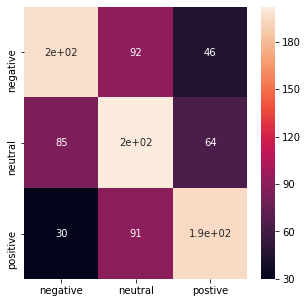

In [0]:
from sklearn import metrics
cm=metrics.confusion_matrix(Y_test,y_pred)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ['negative','neutral','positive'],
                  columns = ['negative','neutral','postive'])
plt.figure(figsize = (5,5))

ax = sn.heatmap(df_cm, annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [0]:
# y_pred = attention_model.predict(xVal)
# y_pred_class = full_model.predict(xVal)

# req = np.argmax(y_pred,axis = 2).reshape((-1))
# classes = np.argmax(y_pred_class,axis=2).reshape(-1)
# imp_vecs = xVal
# pos_words = []
# neg_words = []
# neu_words = []
# for i,vecs in enumerate(imp_vecs):
#     if(classes[i] == 0):
#         neg_words.append({'word':v2w(vecs,avg_vec,)})
#     if(classes[i] == 1):
#         neu_words.append({'word':v2w(vecs)})
#     if(classes[i] == 2):
#         pos_words.append({'word':v2w(vecs)})

# neg_words = pd.DataFrame(neg_words)
# neu_words = pd.DataFrame(neu_words)
# pos_words = pd.DataFrame(pos_words)

# print(neg_words['word'].value_counts())
# print(neu_words['word'].value_counts())
# print(pos_words['word'].value_counts())

##Elmo

In [0]:
xTrain,xVal,yTrain,yVal = getData(normalize=True,k=5000,embed='elmo')
full_model,attention_model = seq2seq(embed='elmo')

rating
1     21619
2      6931
3      6513
4      5012
5      8013
6      6343
7      9456
8     18890
9     27531
10    50989
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rating
1      7299
2      2334
3      2205
4      1659
5      2710
6      2119
7      3091
8      6156
9      9177
10    17016
dtype: int64
label
0     40075
1     14356
2    106866
dtype: int64
label
0    13497
1     4829
2    35440
dtype: int64


100%|██████████| 374434792/374434792 [00:11<00:00, 32457044.78B/s]




:: Lookup of 5000 ELMo representations. This takes a while ::
100%[==================================================] 5000/5000 sentences

:: Lookup of 1000 ELMo representations. This takes a while ::
100%[==================================================] 1000/1000 sentenceslabel
0    1681
1    1641
2    1678
dtype: int64
label
0    323
1    322
2    355
dtype: int64
(5000, 100, 1024) (1000, 100, 1024)
(?, 100, 128)
(?, 64)
(?, 64)
(?, 1, 128)
(?, 1, 100)


In [0]:
training = full_model.fit(x=xTrain, y = yTrain, epochs=15, batch_size=128,validation_split=0.1)

Train on 4500 samples, validate on 500 samples
Epoch 1/15
4500/4500 [==============================] - 14s 3ms/sample - loss: 1.0738 - acc: 0.4218 - val_loss: 1.0276 - val_acc: 0.4660
Epoch 2/15
4500/4500 [==============================] - 12s 3ms/sample - loss: 0.9543 - acc: 0.5422 - val_loss: 0.9799 - val_acc: 0.5140
Epoch 3/15
4500/4500 [==============================] - 12s 3ms/sample - loss: 0.8358 - acc: 0.6260 - val_loss: 0.9441 - val_acc: 0.5320
Epoch 4/15
4500/4500 [==============================] - 12s 3ms/sample - loss: 0.7400 - acc: 0.6756 - val_loss: 0.9717 - val_acc: 0.5200
Epoch 5/15
4500/4500 [==============================] - 12s 3ms/sample - loss: 0.6235 - acc: 0.7504 - val_loss: 1.0851 - val_acc: 0.5160
Epoch 6/15
4500/4500 [==============================] - 12s 3ms/sample - loss: 0.4913 - acc: 0.8149 - val_loss: 1.1109 - val_acc: 0.5200
Epoch 7/15
4500/4500 [==============================] - 12s 3ms/sample - loss: 0.3789 - acc: 0.8600 - val_loss: 1.2224 - val_acc: 0

In [0]:
from sklearn.metrics import classification_report
import numpy as np

Y_test = np.argmax(yVal, axis=2).reshape((-1)) # Convert one-hot to index
y_pred = full_model.predict(xVal)
y_pred = y_pred.argmax(axis=2).reshape((-1))
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58       323
           1       0.49      0.52      0.50       322
           2       0.65      0.61      0.63       355

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000



(3.0, 0.0)

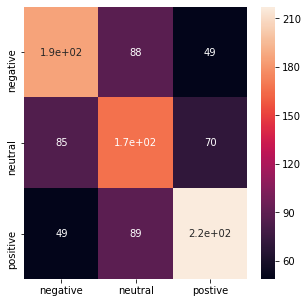

In [0]:
from sklearn import metrics
cm=metrics.confusion_matrix(Y_test,y_pred)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ['negative','neutral','positive'],
                  columns = ['negative','neutral','postive'])
plt.figure(figsize = (5,5))

ax = sn.heatmap(df_cm, annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [0]:
# y_pred = attention_model.predict(xVal)
# y_pred_class = full_model.predict(xVal)

# req = np.argmax(y_pred,axis = 2).reshape((-1))
# classes = np.argmax(y_pred_class,axis=2).reshape(-1)
# imp_vecs = xVal
# pos_words = []
# neg_words = []
# neu_words = []
# for i,vecs in enumerate(imp_vecs):
#     if(classes[i] == 0):
#         neg_words.append({'word':v2w(vecs)})
#     if(classes[i] == 1):
#         neu_words.append({'word':v2w(vecs)})
#     if(classes[i] == 2):
#         pos_words.append({'word':v2w(vecs)})

# neg_words = pd.DataFrame(neg_words)
# neu_words = pd.DataFrame(neu_words)
# pos_words = pd.DataFrame(pos_words)

# print(neg_words['word'].value_counts())
# print(neu_words['word'].value_counts())
# print(pos_words['word'].value_counts())

In [0]:
xTrain,xVal,yTrain,yVal = getData(normalize=True,k=5000,embed='elmo',classes=2)

rating
1     21619
2      6931
3      6513
4      5012
5      8013
6      6343
7      9456
8     18890
9     27531
10    50989
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rating
1      7299
2      2334
3      2205
4      1659
5      2710
6      2119
7      3091
8      6156
9      9177
10    17016
dtype: int64
label
0     48088
1    113209
dtype: int64
label
0    16207
1    37559
dtype: int64


:: Lookup of 5000 ELMo representations. This takes a while ::
100%[==================================================] 5000/5000 sentences

:: Lookup of 1000 ELMo representations. This takes a while ::
100%[==================================================] 1000/1000 sentenceslabel
0    2538
1    2462
dtype: int64
label
0    527
1    473
dtype: int64
(5000, 100, 1024) (1000, 100, 1024)
(?, 100, 128)
(?, 64)
(?, 64)
(?, 1, 128)
(?, 1, 100)


In [0]:
full_model,attention_model = seq2seq(embed='elmo',classes=2)

(?, 100, 128)
(?, 64)
(?, 64)
(?, 1, 128)
(?, 1, 100)


In [0]:
training = full_model.fit(x=xTrain, y = yTrain, epochs=15, batch_size=128,validation_split=0.1)

Train on 4500 samples, validate on 500 samples
Epoch 1/15
4500/4500 [==============================] - 14s 3ms/sample - loss: 0.6650 - acc: 0.5913 - val_loss: 0.5873 - val_acc: 0.6840
Epoch 2/15
4500/4500 [==============================] - 12s 3ms/sample - loss: 0.5402 - acc: 0.7316 - val_loss: 0.5973 - val_acc: 0.6800
Epoch 3/15
4500/4500 [==============================] - 12s 3ms/sample - loss: 0.4628 - acc: 0.7791 - val_loss: 0.4963 - val_acc: 0.7480
Epoch 4/15
4500/4500 [==============================] - 12s 3ms/sample - loss: 0.3618 - acc: 0.8376 - val_loss: 0.5183 - val_acc: 0.7480
Epoch 5/15
4500/4500 [==============================] - 12s 3ms/sample - loss: 0.2553 - acc: 0.8996 - val_loss: 0.5492 - val_acc: 0.7580
Epoch 6/15
4500/4500 [==============================] - 12s 3ms/sample - loss: 0.1552 - acc: 0.9424 - val_loss: 0.7053 - val_acc: 0.7480
Epoch 7/15
4500/4500 [==============================] - 12s 3ms/sample - loss: 0.0748 - acc: 0.9789 - val_loss: 0.8649 - val_acc: 0

In [0]:
from sklearn.metrics import classification_report
import numpy as np

Y_test = np.argmax(yVal, axis=2).reshape((-1)) # Convert one-hot to index
y_pred = full_model.predict(xVal)
y_pred = y_pred.argmax(axis=2).reshape((-1))
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78       527
           1       0.75      0.76      0.75       473

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000



(2.0, 0.0)

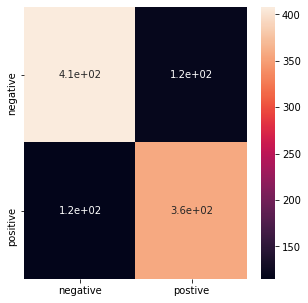

In [0]:
from sklearn import metrics
cm=metrics.confusion_matrix(Y_test,y_pred)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ['negative','positive'],
                  columns = ['negative','postive'])
plt.figure(figsize = (5,5))

ax = sn.heatmap(df_cm, annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [0]:
t

#Training

##General

In [0]:
xTrain,xVal,yTrain,yVal = getData(k=5000)
full_model,attention_model = seq2seq()

In [0]:
training=full_model.fit(x=xTrain, y=yTrain,
  epochs=10,
  validation_split=0.1,
  shuffle=True
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 88s 10ms/sample - loss: 0.7957 - acc: 0.6771 - val_loss: 0.7836 - val_acc: 0.6900
Epoch 2/10
9000/9000 [==============================] - 85s 9ms/sample - loss: 0.7208 - acc: 0.7059 - val_loss: 0.7310 - val_acc: 0.7060
Epoch 3/10
9000/9000 [==============================] - 84s 9ms/sample - loss: 0.6834 - acc: 0.7306 - val_loss: 0.7074 - val_acc: 0.7050
Epoch 4/10
9000/9000 [==============================] - 84s 9ms/sample - loss: 0.6461 - acc: 0.7482 - val_loss: 0.6953 - val_acc: 0.7150
Epoch 5/10
9000/9000 [==============================] - 86s 10ms/sample - loss: 0.6170 - acc: 0.7588 - val_loss: 0.6935 - val_acc: 0.7170
Epoch 6/10
9000/9000 [==============================] - 85s 9ms/sample - loss: 0.5759 - acc: 0.7758 - val_loss: 0.7063 - val_acc: 0.7190
Epoch 7/10
9000/9000 [============

In [0]:
type(training)

tensorflow.python.keras.callbacks.History

In [0]:
full_model.evaluate(xVal,
  y=yVal)

10000/10000 [==============================] - 21s 2ms/sample - loss: 0.8051 - acc: 0.7235


[0.805129394197464, 0.7235]

In [0]:
y_pred = attention_model.predict(xVal)
y_pred_class = full_model.predict(xVal)

In [0]:
req = np.argmax(y_pred,axis = 2).reshape((-1))

In [0]:
classes = np.argmax(y_pred_class,axis=2).reshape(-1)

In [0]:
imp_vecs = xVal

In [0]:
def v2w(vec):
    if((vec==avg_vec).all()):
        return 'UNK'
    if(np.prod(vec) == 0):
        return 'None'
    for k in w2v_dict:
        if((w2v_dict[k]==vec).all()):
            return k
    return 'OOV'

In [0]:
pos_words = []
neg_words = []
neu_words = []
for i,vecs in enumerate(imp_vecs):
    if(classes[i] == 0):
        neg_words.append({'word':v2w(vecs)})
    if(classes[i] == 1):
        neu_words.append({'word':v2w(vecs)})
    if(classes[i] == 2):
        pos_words.append({'word':v2w(vecs)})

In [0]:
neg_words = pd.DataFrame(neg_words)
neu_words = pd.DataFrame(neu_words)
pos_words = pd.DataFrame(pos_words)

In [0]:
print(neg_words['word'].value_counts())
print(neu_words['word'].value_counts())
print(pos_words['word'].value_counts())

bleeding       98
pain           80
i              66
my             65
feel           61
               ..
usually         1
alternative     1
cleanse         1
jerk            1
clot            1
Name: word, Length: 717, dtype: int64
feel        12
my           9
started      8
bleeding     6
like         6
            ..
worked       1
paxil        1
taste        1
helps        1
pure         1
Name: word, Length: 146, dtype: int64
love          374
life          367
my            211
works         209
great         182
             ... 
continued       1
seltzer         1
two             1
eyed            1
obsessions      1
Name: word, Length: 1375, dtype: int64


In [0]:
y_pred_class = full_model.predict({
    'ex':xVal,
    'dx':_GO
  })

y_test = np.argmax(yVal,axis=2)
y_pred_class = np.argmax(y_pred_class,axis=2)

In [0]:
y_test=y_test.reshape((-1))
y_pred_class=y_pred_class.reshape((-1))

In [0]:
from sklearn import metrics

cm=metrics.confusion_matrix(y_test[:k],y_pred_class)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ['negative','neutral','positive'],
                  columns = ['negative','neutral','postive'])
plt.figure(figsize = (5,5))

ax = sn.heatmap(df_cm, annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


In [0]:
import tensorflow as tf
import keras

config = tf.ConfigProto( device_count = {'GPU': 1} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

# from tensorflow.python.client import device_lib

# print(device_lib.list_local_devices())

##Normalized Data

In [0]:
# sequence_length = 100
# num_classes = 3

In [0]:
# data = df['vectors'].to_numpy() #,np.array(df['r_label'])
# data = pad_sequences(df['vectors'], maxlen=sequence_length,dtype='float32')

In [0]:
# # labels = to_categorical(labels,num_classes=3)
# # for l in labels

# labels_e = {'_GO':np.array([0,0,0]),'neg':np.array([1,0,0]),'nut':np.array([0,1,0]),'pos':np.array([0,0,1])}
# def foo2(x):
#   if(x < 5):
#     return [1,0,0]
#   elif(x<7):
#     return [0,1,0]
#   return [0,0,1]

# labels = df.rating.apply(foo2)
# labels = np.array(list(labels))

In [0]:
xTrain,xVal,yTrain,yVal = getData(k=10000)
full_model,attention_model = seq2seq()

In [0]:
xVal.shape

(8400, 100, 50)

In [0]:
training=full_model.fit(x=xTrain,
  y=yTrain,
  epochs=10,
  validation_split=0.1,
  shuffle=True
)

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 85s 9ms/sample - loss: 0.9115 - acc: 0.6133 - val_loss: 0.8558 - val_acc: 0.6010
Epoch 2/10
9000/9000 [==============================] - 85s 9ms/sample - loss: 0.7337 - acc: 0.6841 - val_loss: 0.8703 - val_acc: 0.6100
Epoch 3/10
9000/9000 [==============================] - 85s 9ms/sample - loss: 0.6469 - acc: 0.7301 - val_loss: 0.9072 - val_acc: 0.6150
Epoch 4/10
9000/9000 [==============================] - 86s 10ms/sample - loss: 0.5682 - acc: 0.7684 - val_loss: 0.9604 - val_acc: 0.5880
Epoch 5/10
9000/9000 [==============================] - 85s 9ms/sample - loss: 0.4907 - acc: 0.8013 - val_loss: 1.0351 - val_acc: 0.6010
Epoch 6/10
9000/9000 [==============================] - 85s 9ms/sample - loss: 0.4119 - acc: 0.8460 - val_loss: 1.1464 - val_acc: 0.5870
Epoch 7/10
9000/9000 [==============================] - 85s 9ms/sample - loss: 0.3400 - acc: 0.8764 - val_loss: 1.2578 - val_acc:

In [0]:
full_model.evaluate(xVal,
  y=yVal)

5000/5000 [==============================] - 10s 2ms/sample - loss: 1.2979 - acc: 0.5596


[1.29794847946167, 0.5596]

In [0]:
y_pred = attention_model.predict(xVal)
y_pred_class = full_model.predict(xVal)

In [0]:
req = np.argmax(y_pred,axis = 2).reshape((-1))

In [0]:
classes = np.argmax(y_pred_class,axis=2).reshape(-1)

In [0]:
imp_vecs = xVal

In [0]:
def v2w(vec):
    if((vec==avg_vec).all()):
        return 'UNK'
    if(np.prod(vec) == 0):
        return 'None'
    for k in w2v_dict:
        if((w2v_dict[k]==vec).all()):
            return k
    return 'OOV'

In [0]:
pos_words = []
neg_words = []
neu_words = []
for i,vecs in enumerate(imp_vecs):
    if(classes[i] == 0):
        neg_words.append({'word':v2w(vecs)})
    if(classes[i] == 1):
        neu_words.append({'word':v2w(vecs)})
    if(classes[i] == 2):
        pos_words.append({'word':v2w(vecs)})

In [0]:
neg_words = pd.DataFrame(neg_words)
neu_words = pd.DataFrame(neu_words)
pos_words = pd.DataFrame(pos_words)

In [0]:
print(neg_words['word'].value_counts())
print(neu_words['word'].value_counts())
print(pos_words['word'].value_counts())

i               63
bad             56
life            55
horrible        47
my              35
                ..
knees            1
gut              1
dramatically     1
medicated        1
true             1
Name: word, Length: 504, dtype: int64
i          88
eat        39
started    34
UNK        34
bad        34
           ..
falling     1
just        1
dove        1
rough       1
sweaty      1
Name: word, Length: 537, dtype: int64
life          145
love           89
years          87
great          69
i              36
             ... 
uplifting       1
bile            1
particular      1
weight          1
hope            1
Name: word, Length: 439, dtype: int64


In [0]:
y_pred_class = full_model.predict(xVal)

y_pred_class = np.argmax(y_pred_class,axis=2)
y_pred_class=y_pred_class.reshape((-1))

In [0]:
y_test = np.argmax(yVal,axis=2)
y_test=y_test.reshape((-1))

(3.0, 0.0)

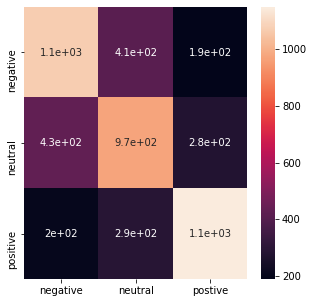

In [0]:
from sklearn import metrics

cm=metrics.confusion_matrix(y_test[:k],y_pred_class)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ['negative','neutral','positive'],
                  columns = ['negative','neutral','postive'])
plt.figure(figsize = (5,5))

ax = sn.heatmap(df_cm, annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


## Binary Classification

In [0]:
xTrain,xVal,yTrain,yVal,_GO,_GO_test = getData(classes=2,k=1000)
full_model,attention_model = seq2seq(classes=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1000, 100, 50) (53766, 100, 50)
(?, 100, 128)
(?, 64)
(?, 64)
(?, 1, 128)
(?, 1, 100)


In [0]:
training=full_model.fit(x={
    'ex':xTrain,
    'dx':_GO
  },
  y=yTrain,
  epochs=10,
  validation_split=0.1,
  shuffle=True
)

Train on 900 samples, validate on 100 samples
Epoch 1/10
900/900 [==============================] - 11s 12ms/sample - loss: 0.6122 - acc: 0.6878 - val_loss: 0.5769 - val_acc: 0.7500
Epoch 2/10
900/900 [==============================] - 9s 10ms/sample - loss: 0.5922 - acc: 0.6878 - val_loss: 0.5130 - val_acc: 0.7600
Epoch 3/10
900/900 [==============================] - 10s 11ms/sample - loss: 0.5759 - acc: 0.7011 - val_loss: 0.4897 - val_acc: 0.7500
Epoch 4/10
900/900 [==============================] - 9s 10ms/sample - loss: 0.5532 - acc: 0.7267 - val_loss: 0.5027 - val_acc: 0.7800
Epoch 5/10
900/900 [==============================] - 9s 10ms/sample - loss: 0.5262 - acc: 0.7356 - val_loss: 0.4738 - val_acc: 0.7600
Epoch 6/10
900/900 [==============================] - 9s 10ms/sample - loss: 0.5122 - acc: 0.7544 - val_loss: 0.4425 - val_acc: 0.7800
Epoch 7/10
900/900 [==============================] - 9s 10ms/sample - loss: 0.4787 - acc: 0.7700 - val_loss: 0.4271 - val_acc: 0.7600
Epoch 8

In [0]:
full_model.evaluate({
    'ex':xVal,
    'dx':_GO_test
  },
  y=yVal)

53766/53766 [==============================] - 121s 2ms/sample - loss: 0.6211 - acc: 0.7204


[0.6211253218944507, 0.7204367]

In [0]:
y_pred = attention_model.predict({
    'ex':xVal,
    'dx':_GO_test
  })
y_pred_class = full_model.predict({
    'ex':xVal,
    'dx':_GO_test
  })

In [0]:
req = np.argmax(y_pred,axis = 2).reshape((-1))

In [0]:
classes = np.argmax(y_pred_class,axis=2).reshape(-1)

In [0]:
imp_vecs = xVal

In [0]:
def v2w(vec):
    if((vec==avg_vec).all()):
        return 'UNK'
    if(vec.sum() == 0):
        return 'None'
    for k in w2v_dict:
        if((w2v_dict[k]==vec).all()):
            return k
    return 'OOV'

In [0]:
pos_words = []
neg_words = []
neu_words = []
for i,vecs in enumerate(imp_vecs):
    if(classes[i] == 0):
        neg_words.append({'word':v2w(vecs)})
    if(classes[i] == 1):
        pos_words.append({'word':v2w(vecs)})

KeyboardInterrupt: ignored

In [0]:
neg_words = pd.DataFrame(neg_words)
pos_words = pd.DataFrame(pos_words)

In [0]:
print(neg_words['word'].value_counts())
print(pos_words['word'].value_counts())

In [0]:
y_pred_class = full_model.predict({
    'ex':xVal,
    'dx':_GO_test
  })

y_pred_class = np.argmax(y_pred_class,axis=2)
y_pred_class=y_pred_class.reshape((-1))

In [0]:
y_test = np.argmax(yVal,axis=2)
y_test=y_test.reshape((-1))

(2.0, 0.0)

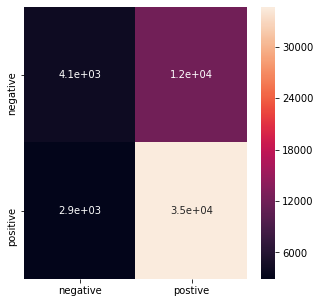

In [0]:
from sklearn import metrics

cm=metrics.confusion_matrix(y_test,y_pred_class)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ['negative','positive'],
                  columns = ['negative','postive'])
plt.figure(figsize = (5,5))

ax = sn.heatmap(df_cm, annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
